<img src="https://raw.githubusercontent.com/deepmind/acme/master/docs/imgs/acme.png" width="50%">
<figcaption></figcaption ></center>
</figure>

# Building an Acme agent (D4PG) manually

In this tutorial colab, we'll take a more in-depth look at Acme components by not
using the `D4PGBuilder` nor the `run_experiment` function and building the
agent's components and connecting them manually.

---
_Warning! This colab has only been tested with **python 3.8 and 3.9** kernels. 
We are working on making it run on the default 3.7 colab kernel. Please bear with us._

# Import Modules

In [ ]:
from typing import Sequence, Tuple

from dm_control import suite
from dm_control.rl import control
from IPython.display import HTML
import jax
import jax.numpy as jnp
import haiku as hk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
import reverb
import rlax
import tensorflow as tf

import acme
from acme import specs
from acme import wrappers
from acme.adders import reverb as reverb_adders
from acme.agents.jax import actors
from acme.agents.jax import actor_core as actor_core_lib
from acme.agents.jax.d4pg import learning
from acme.datasets import reverb as datasets
from acme.jax import utils, variable_utils
from acme.jax import networks as networks_lib
from acme.jax.experiments.run_experiment import _disable_insert_blocking, _LearningActor
from acme.utils import counting
from acme.utils import loggers

# Configure the D4PG agent

Next we must make hyperparameter choices for the agent as these 
will affect the neural network creation.

In [2]:
key = jax.random.PRNGKey(123)

batch_size = 256
learning_rate = 1e-4
discount = 0.99
n_step = 5  # The D4PG agent learns from n-step transitions.
exploration_sigma = 0.3
target_update_period = 100

# Controls the relative rate of sampled vs inserted items. In this case, items
# are n-step transitions.
samples_per_insert = 32.0

# Atoms used by the categorical distributional critic.
num_atoms = 51
critic_atoms = jnp.linspace(-150., 150., num_atoms)

# Load the environment

We first load our desired environment and wrap it to process its input and
output. See the inline comments to inspect the purpose of the individual
wrappers.



In [3]:
# Control suite environments are dm_env.Environments with additional attributes
# such as a `physics` object, which we use to render the scene.
environment: control.Environment = suite.load('cartpole', 'balance')

# Concatenate the observations (position, velocity, etc).
environment = wrappers.ConcatObservationWrapper(environment)

# Make the environment expect continuous action spec is [-1, 1].
# Note: this is a no-op on dm_control tasks.
environment = wrappers.CanonicalSpecWrapper(environment, clip=True)

# Make the environment output single-precision floats.
# We use this because most TPUs only work with float32.
environment = wrappers.SinglePrecisionWrapper(environment)

Finally, we grab its specifications (shapes
and dtypes of observations/actions/rewards/discount), which will be necessary
for specifying the neural network input and output shapes as well as the replay
buffer item signature.

In [4]:
environment_spec = specs.make_environment_spec(environment)

# Create the Haiku networks

Here we recreate the D4PG default neural networks of the same size as those used
in the quickstart colab.


In [5]:
# Calculate how big the last layer should be based on total # of actions.
action_spec = environment_spec.actions
action_size = np.prod(action_spec.shape, dtype=int)

# Create the deterministic policy network.
def policy_fn(obs: networks_lib.Observation) -> jnp.ndarray:
  x = obs
  x = networks_lib.LayerNormMLP([256, 256], activate_final=True)(x)
  x = networks_lib.NearZeroInitializedLinear(action_size)(x)
  x = networks_lib.TanhToSpec(action_spec)(x)
  return x

# Create the distributional critic network.
def critic_fn(
    obs: networks_lib.Observation,
    action: networks_lib.Action,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
  x = jnp.concatenate([obs, action], axis=-1)
  x = networks_lib.LayerNormMLP(layer_sizes=[256, 256, num_atoms])(x)
  return x, critic_atoms

This is how Haiku transforms the simple functions above into two functions:
- init, which returns the parameters and
- apply, which applies the neural network to inputs given parameters.

In [6]:
policy = hk.without_apply_rng(hk.transform(policy_fn))
critic = hk.without_apply_rng(hk.transform(critic_fn))

In order to create the neural network parameters, we create dummy versions of
the environments observations and actions. This allows us to prebind the network
`init` methods so that only a random key is needed to initialize parameters.

In [7]:
# Create dummy observations and actions to create network parameters.
dummy_action = utils.zeros_like(environment_spec.actions)
dummy_obs = utils.zeros_like(environment_spec.observations)

# Prebind dummy observations and actions so they are not needed in the learner.
policy_network = networks_lib.FeedForwardNetwork(
    init=lambda rng: policy.init(rng, dummy_obs),
    apply=policy.apply)
critic_network = networks_lib.FeedForwardNetwork(
    init=lambda rng: critic.init(rng, dummy_obs, dummy_action),
    apply=critic.apply)

Finally we create an exploration policy by simply wrapping the policy network
to add Gaussian noise with the exploration sigma specified in the "Configure
the D4PG agent" cell.

In [8]:
def exploration_policy(
    params: networks_lib.Params,
    key: networks_lib.PRNGKey,
    observation: networks_lib.Observation,
) -> networks_lib.Action:
  action = policy_network.apply(params, observation)
  if exploration_sigma:
    action = rlax.add_gaussian_noise(key, action, exploration_sigma)
  return action

# Create a D4PG agent components

In this section we create the agent components manually one by
one. Note that this is usually done by the `run_experiment` or
`make_distributed_experiment` script but for the purposes of
this tutorial we create and use them explicitly.

The run scripts make use of the agent builder (in this case
`D4PGBuilder`), which we don't use here since this tutorial is
partially meant to peel this layer of abstraction to demystify
the builder.


## Create a central counter

This is the parent counter to which all other component counters
will synchronize their counts (of their corresponding steps,
walltimes, etc).

In [9]:
parent_counter = counting.Counter(time_delta=0.)

## Create the replay table

In [10]:
# Manages the data flow by limiting the sample and insert calls.
rate_limiter = reverb.rate_limiters.SampleToInsertRatio(
    min_size_to_sample=1000,
    samples_per_insert=samples_per_insert,
    error_buffer=2 * batch_size)

# Create a replay table to store previous experience.
replay_tables = [
    reverb.Table(
        name='priority_table',
        sampler=reverb.selectors.Uniform(),
        remover=reverb.selectors.Fifo(),
        max_size=1_000_000,
        rate_limiter=rate_limiter,
        signature=reverb_adders.NStepTransitionAdder.signature(
            environment_spec))
]

In single-process execution, acting (data generation and _insertion_) and 
learning (_sampling_ and data consumption) is done sequentially.

Below we make sure that consumption happens only when enough data (a batch) is
ready, otherwise acting continues. We avoid the actor's inserts blocking by
disabling Reverb's rate limitation in one direction (inserts).

***Note!*** *This is the first of three code cells that are specific to
single-process execution. (This is done for you when you use an agent `Builder`
and `run_experiment`.) Everything else is logic shared between the two.*

In [11]:
# NOTE: This is the first of three code cells that are specific to
# single-process execution. (This is done for you when you use an agent
# `Builder` and `run_experiment`.) Everything else is logic shared between the
# two.
replay_tables, rate_limiters_max_diff = _disable_insert_blocking(replay_tables)

Finally we create the replay buffer server and client.

In [ ]:
replay_server = reverb.Server(replay_tables, port=None)
replay_client = reverb.Client(f'localhost:{replay_server.port}')

## Create the learner's dataset iterator

In [13]:
# Pull data from the Reverb server into a TF dataset the agent can consume.
dataset = datasets.make_reverb_dataset(
    table='priority_table',
    server_address=replay_client.server_address,
    batch_size=batch_size,
)

# We use multi_device_put here in case this colab is run on a machine with
# multiple accelerator devices, but this works fine with single-device learners
# as long as their step functions are pmapped.
dataset = utils.multi_device_put(dataset.as_numpy_iterator(), jax.devices())

In single-process execution we must always use this `utils.prefetch` function.

***Note!*** *This is the second of three code cells that are specific to
single-process execution. (This is done for you when you use an agent `Builder`
and `run_experiment`.) Everything else is logic shared between the two.*

This utility function produces an identical iterator with an
additional `.ready()` method. The `_LearningActor` (only to be
used within `run_experiment`) then uses the `iterator.ready()`
method to avoid deadlocks in single-process execution.

In [14]:
# NOTE: This is the second of three code cells that are specific to
# single-process execution. (This is done for you when you use an agent
# `Builder` and `run_experiment`.) Everything else is logic shared between the
# two.
dataset = utils.prefetch(dataset, buffer_size=1)

## Create the learner

In [15]:
key, learner_key = jax.random.split(key)

# The learner updates the parameters (and initializes them).
learner = learning.D4PGLearner(
    policy_network=policy_network,
    critic_network=critic_network,
    random_key=learner_key,
    policy_optimizer=optax.adam(learning_rate),
    critic_optimizer=optax.adam(learning_rate),
    discount=discount,
    target_update_period=target_update_period,
    iterator=dataset,
    # A simple counter object that can periodically sync with a parent counter.
    counter=counting.Counter(parent_counter, prefix='learner', time_delta=0.),
)

## Create the adder

In [16]:
# Handles preprocessing of data and insertion into replay tables.
adder = reverb_adders.NStepTransitionAdder(
    priority_fns={'priority_table': None},
    client=replay_client,
    n_step=n_step,
    discount=discount)

## Create the actor

In [17]:
key, actor_key = jax.random.split(key)

# A convenience adaptor from FeedForwardPolicy to ActorCore.
actor_core = actor_core_lib.batched_feed_forward_to_actor_core(
    exploration_policy)

# A variable client for updating variables from a remote source.
variable_client = variable_utils.VariableClient(learner, 'policy', device='cpu')
actor = actors.GenericActor(
    actor=actor_core,
    random_key=actor_key,
    variable_client=variable_client,
    adder=adder,
    backend='cpu')

Replace the actor with a `_LearningActor`.

***Note!*** *This is the third of three code cells that are specific to
single-process execution. (This is done for you when you use an agent `Builder`
and `run_experiment`.) Everything else is logic shared between the two.*

Every `update` call, the `_LearningActor` checks whether there is enough new data to learn from; if so it runs a learner step,
otherwise it cedes control back to the environment loop.
Thus it avoids deadlocks whereby the learner is asked to update
but the iterator does not have a batch of data ready for it.

As usual the rate at which new data is released is controlled
by the replay table's rate_limiter which is created by the
builder.make_replay_tables call above.



In [18]:
# NOTE: This is the third of three code cells that are specific to
# single-process execution. (This is done for you when you use an agent
# `Builder` and `run_experiment`.) Everything else is logic shared between the
# two.
actor = _LearningActor(actor, learner, dataset, replay_tables,
                       rate_limiters_max_diff, checkpointer=None)

In [19]:
env_loop_logger = loggers.InMemoryLogger()

# Create the environment loop used for training.
env_loop = acme.EnvironmentLoop(
    environment,
    actor,
    counter=counting.Counter(parent_counter, prefix='train', time_delta=0.),
    logger=env_loop_logger)

# Run a training loop

This may take a while... If you're feeling impatient consider reducing the
number of episodes down to 5 in the following cell and rerun it until the
plot in the next cell approaches the top score of 1000. 

In [ ]:
env_loop.run(num_episodes=50)

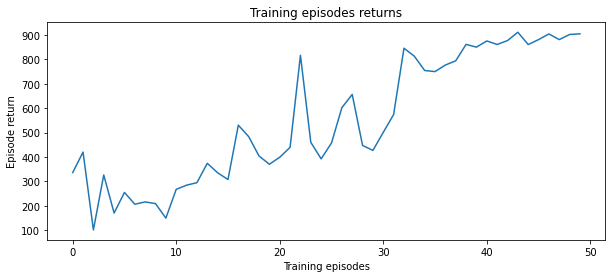

In [21]:
%matplotlib inline
df = pd.DataFrame(env_loop_logger.data)
plt.figure(figsize=(10, 4))
plt.title('Training episodes returns')
plt.xlabel('Training episodes')
plt.ylabel('Episode return')
plt.plot(df['episode_return']);

# Run and visualize the agent in the environment

For this run we wrap the environment so that every timestep is rendered allowing
us to create and display a video.

**Warning!** Rendering is expensive! Make sure you don't wrap the environment
used for gathering data in the training loop above. We name this environment
differently in case you want to run the training loop again after visualizing
the agent here.

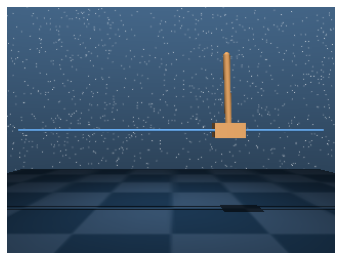

In [22]:
# Make the environment render frames and produce videos of episodes.
eval_environment = wrappers.MujocoVideoWrapper(environment, record_every=1)

timestep = eval_environment.reset()

while not timestep.last():
  action = actor.select_action(timestep.observation)
  timestep = eval_environment.step(action)

# Embed the HTML video.
HTML(eval_environment.make_html_animation())